# Model 1: Credit Default Risk

## Setup

**Imports:**

In [103]:
%reload_ext autoreload
%autoreload 1
import shap
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import mlflow
from pprint import pprint
import random
import polars as pl
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from rgf.sklearn import RGFClassifier
import auxiliary.transformers as tr
from auxiliary.transformers import PolarsColumnTransformer as PCT
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import copy
import auxiliary.tuning as tunes
import auxiliary.eda_functions as eda
from ray import tune
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from BorutaShap import BorutaShap
import statistics
from sklearn.utils.validation import check_random_state
%aimport auxiliary.transformers
%aimport auxiliary.tuning
%aimport auxiliary.eda_functions

**Settings:**

In [2]:
random.seed(1)

**Loading the data:**

In [3]:
train_data = pl.read_parquet("temp/application_train_filtered.parquet")
id_and_target = ["SK_ID_CURR", "TARGET"]
X_train = train_data.drop(columns=id_and_target)
y_train = train_data["TARGET"]

**Specifying categoric numeric and boolean features:**

In [4]:
bool_features = []
for feature in X_train.select(pl.col(pl.Utf8)).columns:
    if X_train[feature].n_unique() == 2:
        bool_features.append(feature)

cat_features = [
    feature
    for feature in X_train.select(pl.col(pl.Utf8)).columns
    if feature not in bool_features
]

numeric_features_with_nulls = (
    pl.Series(
        X_train.select(pl.col(pl.FLOAT_DTYPES), pl.col(pl.INTEGER_DTYPES)).columns
    )
    .filter(
        X_train.select(pl.col(pl.FLOAT_DTYPES), pl.col(pl.INTEGER_DTYPES))
        .select(pl.all().is_null().any())
        .transpose()
        .to_series()
    )
    .to_list()
)

## Pipelines

### Preprocessing pipeline

In [19]:
preprocessing = Pipeline([])

num_imputer = tr.PolarsColumnTransformer([])
for feature in numeric_features_with_nulls:
    num_imputer.steps[feature] = PCT.Step(feature, tr.NumDiffFromRestImputer(), feature)
preprocessing.steps.insert(0, ("num_imputer", num_imputer))

cat_imputers = tr.PolarsColumnTransformer([])
for feature in cat_features:
    cat_imputers.steps[feature] = PCT.Step(
        feature, tr.NotInImputerPolars(min_values=100, fill_value="other"), feature
    )
preprocessing.steps.append(("cat_imputers", cat_imputers))

encoders = tr.PolarsColumnTransformer([])
for feature in bool_features:
    encoders.steps[feature] = PCT.Step(
        feature, tr.PolarsOneHotEncoder(drop=True), feature
    )
for feature in cat_features:
    encoders.steps[feature] = PCT.Step(
        feature, tr.TargetMeanOrderedLabeler(how="label"), feature
    )
preprocessing.steps.append(("encoders", encoders))
preprocessing.steps.append(("emergency_null_imputer", tr.PolarsNullImputer(-9999)))
feature_remover = tr.FeatureRemover([])
preprocessing.steps.append(("feature_removal", feature_remover))

The preprocessing pipeline involves several key steps:

1. **Handling Missing Values in Numeric Features:** Null values in numeric features are encoded as a distinct number deviating from the rest. The sign of this deviation is determined by comparing the target mean of the nulls to the rest of the data, taking into account the sign of Pearson's correlation coefficient.

2. **Pooling Classes in Categorical Features:** Classes in categorical features with fewer than 100 values are consolidated into an "other" class.

3. **One-Hot Encoding for Boolean Features:** Boolean features are encoded using one-hot encoding, transforming them into binary representations.

4. **Labeling Categorical Features:** Categorical features are assigned numerical labels, and the order is determined by the target mean in the training set.

5. **Feature Removal Transformer:** A feature removal transformer is integrated into the pipeline to facilitate testing different sets of features during the parameter tuning phase. This allows for experimentation with various feature subsets to optimize model performance.

### Models and Sampling:

**LightGBM**

In [6]:
model_lgb = LGBMClassifier(n_jobs=1, verbosity=-1, force_col_wise=True)
sampler_model = tr.SamplingModelWrapper(model_lgb)
full_pipeline = Pipeline([("preprocess", preprocessing), ("model", sampler_model)])

**Extra Trees**

In [7]:
preprocessing_etrees = copy.deepcopy(preprocessing)
model_extra_trees = ExtraTreesClassifier(random_state=1, n_jobs=1)
sampler_model_etrees = tr.SamplingModelWrapper(model_extra_trees)
full_pipeline_etrees = Pipeline(
    [("preprocess", preprocessing_etrees), ("model", sampler_model_etrees)]
)

**Regularized Greedy Forest**

In [20]:
preprocessing_rgf = copy.deepcopy(preprocessing)
model_rgf = RGFClassifier()
sampler_model_rgf = tr.SamplingModelWrapper(model_rgf)
full_pipeline_rgf = Pipeline(
    [("preprocess", preprocessing_rgf), ("model", sampler_model_rgf)]
)

## Feature Selection:

The feature selection process is executed using the Boruta algorithm implementation, leveraging SHAP values for feature importance. The underlying classifier for feature selection is a LightGBM (LGBM) classifier. LightGBM models inherently possess feature-wise regularization parameters, such as the l1 and l2 penalties. To explore the impact of these regularization parameters on the Boruta algorithm, three separate runs of feature selection were conducted with L1 penalties set at 0, 1, and 10. This experimental approach allows for an examination of how varying regularization parameters influence the identification of significant features.

**Fitting Boruta Shap algorithm on LGBM models with different alpha regularization values**

**Creating lists of bad and tentative feature lists for each selection experiment:**

In [22]:
selector_with_alpha = joblib.load("temp/model_1_selector_alpha1.joblib")
selector_high_alpha = joblib.load("temp/model_1_selector_alpha10.joblib")
selector_no_alpha = joblib.load("temp/model_1_selector_alpha0.joblib")
bad_features_with_alpha = selector_with_alpha.features_to_remove.tolist()
bad_and_tentative_features_alpha = bad_features_with_alpha.copy()
bad_and_tentative_features_alpha.extend(selector_with_alpha.tentative.copy())


bad_features_high_alpha = selector_high_alpha.features_to_remove.tolist()
bad_and_tentative_features_high_alpha = bad_features_high_alpha.copy()
bad_and_tentative_features_high_alpha.extend(selector_high_alpha.tentative.copy())


bad_feature_no_alpha = selector_no_alpha.features_to_remove.tolist()
bad_and_tentative_features_no_alpha = bad_feature_no_alpha.copy()
bad_and_tentative_features_no_alpha.extend(selector_no_alpha.tentative.copy())

**Putting the feature quality data into a single data frame:**

In [23]:
feature_quality = {"feature": preprocessing.fit_transform(X_train, y_train).columns}
feature_quality["high_alpha"] = []
feature_quality["alpha"] = []
feature_quality["no_alpha"] = []

for feature in feature_quality["feature"]:
    if feature in bad_features_high_alpha:
        feature_quality["high_alpha"].append("bad")
    elif feature in selector_high_alpha.tentative:
        feature_quality["high_alpha"].append("tentative")
    else:
        feature_quality["high_alpha"].append("good")

for feature in feature_quality["feature"]:
    if feature in bad_features_with_alpha:
        feature_quality["alpha"].append("bad")
    elif feature in selector_with_alpha.tentative:
        feature_quality["alpha"].append("tentative")
    else:
        feature_quality["alpha"].append("good")

for feature in feature_quality["feature"]:
    if feature in bad_features_high_alpha:
        feature_quality["no_alpha"].append("bad")
    elif feature in selector_no_alpha.tentative:
        feature_quality["no_alpha"].append("tentative")
    else:
        feature_quality["no_alpha"].append("good")

feature_quality = pl.DataFrame(feature_quality)

**Features with no consensus:**

In [24]:
eda.table_display(
    feature_quality.filter(
        (pl.col("high_alpha") != pl.col("alpha"))
        | (pl.col("high_alpha") != pl.col("no_alpha"))
        | (pl.col("alpha") != pl.col("no_alpha"))
    )
)

| feature                                   | high_alpha   | alpha     | no_alpha   |
|:------------------------------------------|:-------------|:----------|:-----------|
| AMT_INCOME_TOTAL                          | good         | good      | tentative  |
| DAYS_REGISTRATION                         | tentative    | good      | good       |
| FLAG_WORK_PHONE                           | tentative    | good      | good       |
| LIVINGAREA_MEDI                           | bad          | tentative | bad        |
| DEF_60_CNT_SOCIAL_CIRCLE                  | bad          | tentative | bad        |
| bureau_DAYS_CREDIT_ENDDATE_max            | tentative    | tentative | good       |
| bureau_AMT_CREDIT_MAX_OVERDUE_max         | tentative    | tentative | good       |
| bureau_AMT_CREDIT_SUM_mean                | tentative    | good      | good       |
| bureau_AMT_CREDIT_SUM_max                 | tentative    | tentative | good       |
| bureau_AMT_CREDIT_SUM_LIMIT_mean          | bad          | tentative | bad        |
| bureau_DAYS_CREDIT_mean                   | tentative    | good      | good       |
| bureau_DAYS_CREDIT_sum                    | bad          | tentative | bad        |
| bureau_DAYS_CREDIT_UPDATE_std             | bad          | tentative | bad        |
| bureau_DAYS_CREDIT_ENDDATE_mean_Active    | tentative    | good      | good       |
| bureau_DAYS_CREDIT_ENDDATE_mode_Active    | bad          | tentative | bad        |
| bureau_AMT_CREDIT_MAX_OVERDUE_mean_Active | bad          | tentative | bad        |
| bureau_AMT_CREDIT_SUM_mean_Active         | bad          | tentative | bad        |
| bureau_AMT_CREDIT_SUM_DEBT_sum_Active     | bad          | tentative | bad        |
| bureau_DAYS_CREDIT_mean_Active            | bad          | tentative | bad        |
| prev_AMT_CREDIT_mean_Approved             | bad          | tentative | bad        |
| prev_AMT_CREDIT_sum_Revolving_loans       | tentative    | tentative | good       |
| NAME_INCOME_TYPE                          | tentative    | good      | good       |
| NAME_HOUSING_TYPE                         | bad          | tentative | bad        |
| WALLSMATERIAL_MODE                        | bad          | tentative | bad        |
| NAME_CONTRACT_TYPE_Cash loans             | tentative    | good      | good       |

**Feature quality counts by from different experiments:**

In [119]:
quality_counts = (
    feature_quality["high_alpha"]
    .value_counts()
    .join(
        feature_quality["alpha"].value_counts(),
        left_on="high_alpha",
        right_on="alpha",
        suffix="_alpha",
    )
    .join(
        feature_quality["no_alpha"].value_counts(),
        left_on="high_alpha",
        right_on="no_alpha",
        suffix="_no_alpha",
    )
)
quality_counts = quality_counts.rename(
    {"high_alpha": "quality", "counts": "counts_high_alpha"}
)
quality_counts

quality,counts_high_alpha,counts_alpha,counts_no_alpha
str,u32,u32,u32
"""tentative""",16,22,6
"""good""",47,54,57
"""bad""",169,156,169


The variability in feature selection outcomes from different runs of the Boruta algorithm, based on LightGBM with various L1 penalties, led to the observation that the 0 penalty run tended to be less strict compared to the run with the highest penalty. As there were no completely contradictory disagreements between the iterations (i.e., good vs. bad), only tentative vs. good or bad, a voting mechanism was implemented to make decisions on these features. Two lists were generated: one containing features classified as bad, and another containing both bad and tentative features. These lists of features earmarked for removal will be subjected to tuning alongside hyperparameters, with the aim of selecting the best feature set for the model.

**Creating lists of bad and tentative features from consensus:**

In [25]:
feature_quality = feature_quality.with_columns(
    feature_quality.map_rows(lambda x: statistics.mode(x[1:]))
    .to_series()
    .alias("consensus")
)

consensus_bad_tentative_features = feature_quality.filter(
    pl.col("consensus") != "good"
)["feature"].to_list()
consensus_bad_features = feature_quality.filter(pl.col("consensus") == "bad")[
    "feature"
].to_list()
feature_removal_list = [consensus_bad_features, consensus_bad_tentative_features]

## Hyperparameter Tuning

### Parameter Search Spaces

**LightGBM parameter space:**

In [13]:
models = tunes.Models()
model_params_lgb = {
    "max_depth": tune.randint(5, 30),
    "num_leaves": tune.randint(10, 1000),
    "n_estimators": tune.randint(10, 251),
    "learning_rate": tune.loguniform(0.001, 0.1),
    "bagging_freq": tune.randint(0, 11),
    "colsample_bytree": tune.uniform(0.2, 1.0),
    "subsample": tune.uniform(0.2, 1.0),
    "reg_alpha": tune.loguniform(0.001, 100),
    "reg_lambda": tune.loguniform(0.001, 100),
    "boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "class_weight": tune.choice(["balanced", None]),
    "max_bin": tune.randint(5, 201),
}

search_space_lgbm = {
    "preprocess__feature_removal__feats_to_drop": tune.choice(feature_removal_list),
    "model__model_params": model_params_lgb,
    "model__sampler": tune.choice(["random", None]),
}

models.add_model("lgbm", full_pipeline, search_space_lgbm, metric_threshold=0.77)

**Extra Trees parameter space:**

In [14]:
model_params_extra_trees = {
    "n_estimators": tune.randint(10, 251),
    "max_depth": tune.randint(5, 30),
    "max_leaf_nodes": tune.randint(30, 1000),
    "min_samples_split": tune.randint(2, 21),
    "min_samples_leaf": tune.randint(1, 21),
    "max_features": tune.uniform(0.1, 1.0),
    "class_weight": tune.choice(["balanced", "balanced_subsample", None]),
    "max_samples": tune.uniform(0.1, 1.0),
}

search_space_extra_trees = {
    "preprocess__feature_removal__feats_to_drop": tune.choice(feature_removal_list),
    "model__model_params": model_params_extra_trees,
    "model__sampler": tune.choice(["random", None]),
}

models.add_model(
    "extra_trees", full_pipeline_etrees, search_space_extra_trees, metric_threshold=0.73
)

**Regularized Greedy Forest parameter space:**

In [26]:
model_params_rgf = {
    "algorithm": tune.choice(["RGF", "RGF Opt", "RGF Sib"]),
    "loss": tune.choice(["LS", "Expo", "Log", "Abs"]),
    "l2": tune.loguniform(1e-6, 1.0),
    "max_leaf": tune.randint(10, 1000),
    "test_interval": tune.quniform(100, 1000, 100),
    "reg_depth": tune.randint(1, 21),
    "learning_rate": tune.loguniform(1e-6, 1.0),
}

search_space_rgf = {
    "preprocess__feature_removal__feats_to_drop": tune.choice(feature_removal_list),
    "model__model_params": model_params_rgf,
    "model__sampler": tune.choice(["random", None]),
}

models.add_model("rgf", full_pipeline_rgf, search_space_rgf, metric_threshold=0.76)

### Hyperparameter tuning:

The models were organized and managed within a class named "Models," which includes methods for hyperparameter tuning using the Ray Tune suite. Optuna, an optimization algorithm, was employed to tune the models, and the number of trials varied from 50 to 200 based on the complexity of the model's parameter space. The effectiveness of a set of parameters was assessed through a 5-fold stratified cross-validation, utilizing the roc-auc score as the evaluation metric. To expedite the process, a preset threshold was implemented for early stopping unpromising trials, ensuring that only the best parameter sets underwent evaluation across all 5 cross-validation iterations. The entire process was parallelized for improved efficiency.

For the Regularized Greedy Forest model, hyperparameter tuning was conducted using a subsample of 100,000 due to its slower performance.

**Tuning of each model and saving the results:**

**Loading the tuned models:**

In [5]:
models = joblib.load("temp/model_1_tuned_models.joblib")

### Hyperparameter Tuning Results

**Best parameters:**

In [17]:
for model in models.models.values():
    print(model.name)
    print("----------------")
    for key, param in model.best_params.items():
        if key[:3] == "mod":
            pprint(key + ":")
            pprint(param)
            print("")

lgbm
----------------
'model__model_params:'
{'bagging_freq': 7,
 'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 0.5675594313892778,
 'learning_rate': 0.0020531520402746173,
 'max_bin': 66,
 'max_depth': 29,
 'n_estimators': 203,
 'num_leaves': 784,
 'reg_alpha': 6.125264822058344,
 'reg_lambda': 0.012163660310995155,
 'subsample': 0.9332262165733625}

'model__sampler:'
None

extra_trees
----------------
'model__model_params:'
{'class_weight': 'balanced_subsample',
 'max_depth': 27,
 'max_features': 0.9302655328245393,
 'max_leaf_nodes': 948,
 'max_samples': 0.42946248358997485,
 'min_samples_leaf': 13,
 'min_samples_split': 9,
 'n_estimators': 119}

'model__sampler:'
'random'

rgf
----------------
'model__model_params:'
{'algorithm': 'RGF Sib',
 'l2': 0.0037248443997315024,
 'learning_rate': 0.007618021362344675,
 'loss': 'Expo',
 'max_leaf': 955,
 'reg_depth': 15,
 'test_interval': 400.0}

'model__sampler:'
'random'



**Which features have been removed for each model:**

In [18]:
for model in models.models.values():
    print(model.name)
    if (
        model.best_params["preprocess__feature_removal__feats_to_drop"]
        == consensus_bad_features
    ):
        print("Only bad features removed")
        print("")
    else:
        print("Bad and Tentative features removed")
        print("")

lgbm
Bad and Tentative features removed

extra_trees
Bad and Tentative features removed

rgf
Only bad features removed



The tuning results highlighted distinct strategies for each model:

- **LGBM Model:** No oversampling yielded the best performance. The model benefited from Dropouts meet Multiple Additive Regression Trees (DART) algorithm, featuring a high alpha regularization parameter, a slow learning rate, 203 estimators, and a limit of 784 leaves.

- **Extra Trees Model:** Random oversampling proved beneficial. The optimal model configuration included 119 estimators and was restricted to 948 leaf nodes. Both bad and tentative features were removed.

- **Regularized Greedy Forest (RGF) Model:** Random oversampling was advantageous. The best-performing RGF model had a learning rate of 0.047 and was constrained to 955 max leaf nodes. Only bad features were removed to enhance model performance.


## Model Selection

**Open a server for model performance tracking:**

**KFold Cross-validations of each model:**

**Visualizing the results of ROC-AUC cross-validations:**

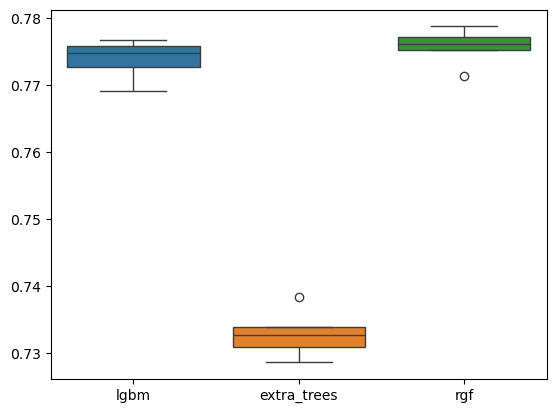

In [30]:
scores = joblib.load("temp/model_1_base_scores.joblib")
fig_scores, ax_scores = plt.subplots()
sns.boxplot(scores)
ax_scores.set_xticklabels(scores.columns)
plt.show()

The Regularized Greedy Forest (RGF) model emerged as the most promising, exhibiting superior results across various evaluation metrics. Its average performance, deviation, and the range of values (min-max) in cross-validations surpassed those of the other models. 

### Model Stacking

To enhance performance further, a stacked model was devised by incorporating the results of all three models. In this ensemble approach, LightGBM (LGBM) was chosen as the final estimator for the stacked model.

To overcome compatibility issues with the sklearn implementation of the stacked model, a custom implementation was crafted. This custom implementation generates k-fold predictions from each model, along with its corresponding preprocessing pipeline. Subsequently, the final estimator is fitted on these predictions to generate the ultimate result.

**Defining the stacked model:**

In [30]:
final_estimator = LGBMClassifier(random_state=1, n_jobs=1, verbose=-1)
model_stack = tr.SimplerStacker(
    [model.pipeline for model in models.models.values()],
    final_estimator=final_estimator,
)

**Performing cross-validations on the stacked model:**

**Mean roc-auc of the stacked model:**

In [26]:
stacked_model_scores = joblib.load("temp/stack_scores.joblib")
np.array(stacked_model_scores).mean()

0.7757698132575065

**Visualizing the cross-validation results:**

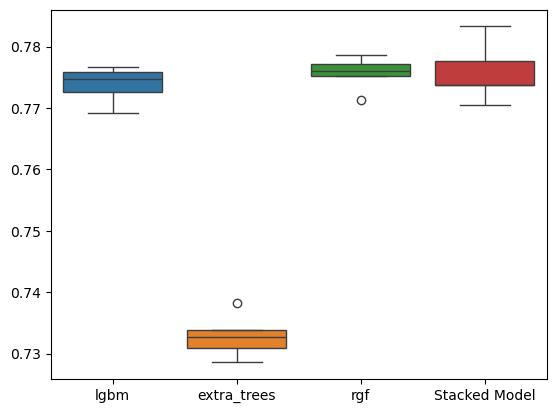

In [36]:
scores = scores.with_columns(pl.Series(stacked_model_scores).alias("Stacked Model"))
fig_scores_full, ax_scores_full = plt.subplots()
sns.boxplot(scores, ax=ax_scores_full)
ax_scores_full.set_xticklabels(scores.columns)
plt.show()

**Base model importances in the stacked model:**

In [43]:
pl.DataFrame(
    {
        "Model": ["LGBM", "Extra Trees", "RGF"],
        "Importance": model_stack.final_estimator.feature_importances_,
    }
).sort("Importance", descending=True)

Model,Importance
str,i32
"""RGF""",1160
"""LGBM""",1109
"""Extra Trees""",731


Despite the implementation of the stacked model, the results did not exhibit a significant improvement. While the maximum value from the cross-validation was higher than that of the RGF model, the mean was nearly identical. However, a notable increase in deviation between iterations was observed, indicating a susceptibility to overfitting.

## Model Testing

**Loading the test data:**

In [7]:
X_test = pl.read_parquet("temp/application_test_filtered.parquet")

### Testing the performance

#### Testing using all available data

**Fitting the chosen RGF model and to the test set and making predictions:**

In [32]:
models.models["rgf"].pipeline.fit(X_train, y_train)
preds_rgf = models.models["rgf"].pipeline.predict_proba(X_test.drop(id_and_target))[
    :, 1
]
preds_rgf = pl.DataFrame([X_test["SK_ID_CURR"], pl.Series(preds_rgf).alias("TARGET")])
preds_rgf.write_csv("submissions/rgf_sumbission.csv")

Submitting the predictions from the test set to Kaggle for a late submission and obtaining the ROC-AUC score provided an external validation of the model's performance on an independent dataset.

**ROC-AUC score from Kaggle on the test set:**

![Kaggle ROC-AUC Score.](summary_data/kaggle_score.png)

Achieving a ROC-AUC score of 0.767 for the model that incorporates all available data, including external source data, represents a notable improvement compared to the baseline score of 0.719. This outcome demonstrates that the intermediate success criteria have been met: the developed model surpasses the performance of a logistic regression model trained solely on external data.

#### Testing without the external source data

**Preparing the model for fitting on data without external source information:**

In [55]:
preprocessing_rgf_no_ext = copy.deepcopy(preprocessing_rgf)
del preprocessing_rgf_no_ext["num_imputer"].steps["EXT_SOURCE_1"]
del preprocessing_rgf_no_ext["num_imputer"].steps["EXT_SOURCE_2"]
del preprocessing_rgf_no_ext["num_imputer"].steps["EXT_SOURCE_3"]
sampler_model_rgf_no_ext = copy.deepcopy(sampler_model_rgf)
full_pipeline_rgf_no_ext = Pipeline(
    [("preprocess", preprocessing_rgf_no_ext), ("model", sampler_model_rgf_no_ext)]
)
full_pipeline_rgf_no_ext.set_params(**models.models["rgf"].best_params)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('num_imputer',
                                  PolarsColumnTransformer(steps=OrderedDict([('AMT_ANNUITY',
                                                                              <auxiliary.transformers.PolarsColumnTransformer.Step object at 0x7f1b26f440d0>),
                                                                             ('AMT_GOODS_PRICE',
                                                                              <auxiliary.transformers.PolarsColumnTransformer.Step object at 0x7f1b26f449a0>),
                                                                             ('OWN_CAR_AGE',
                                                                              <auxiliary.transformers.PolarsColumnTransfo...
                                                                'LANDAREA_MODE',
                                                                'LIVINGAPARTMENTS_MODE',
                                                                'LIVINGAREA_MODE',
                                                                'NONLIVINGAPARTMENTS_MODE',
                                                                'NONLIVINGAREA_MODE', ...]))])),
                ('model',
                 SamplingModelWrapper(model=RGFClassifier(),
                                      model_params={'algorithm': 'RGF Sib',
                                                    'l2': 0.0037248443997315024,
                                                    'learning_rate': 0.007618021362344675,
                                                    'loss': 'Expo',
                                                    'max_leaf': 955,
                                                    'reg_depth': 15,
                                                    'test_interval': 400.0},
                                      sampler='random'))])

**Fitting the model on data with the external source omitted:**

In [59]:
full_pipeline_rgf_no_ext.fit(
    X_train.drop(["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]), y_train
)

preds_rgf_no_ext = full_pipeline_rgf_no_ext.predict_proba(
    X_test.drop(id_and_target).drop(["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"])
)[:, 1]

preds_rgf_no_ext = pl.DataFrame(
    [X_test["SK_ID_CURR"], pl.Series(preds_rgf_no_ext).alias("TARGET")]
)

preds_rgf_no_ext.write_csv("submissions/no_ext_submission.csv")

**ROC-AUC score from Kaggle on the test set for a model without external source data:**

![Kaggle ROC-AUC Score.](summary_data/kaggle_score_no_ext.png)

Achieving a ROC-AUC score of 0.749 on the test set without using external source data surpasses the established baseline of 0.719. This result confirms that the model fully meets the success criteria, demonstrating its efficacy in predicting default risk even without relying on external data.

### Feature Importance

The evaluation of feature importance employed two distinct methods: the model's internal feature importance values and SHAP values. Each method has its advantages and limitations.

1. **Model's Internal Feature Importance:** These values gauge the importance of features based on the model's overall performance on the entire dataset. However, they may overlook rare classes that are crucial in specific cases, as they focus on the model's aggregate behavior.

2. **SHAP Values:** SHAP values provide a more nuanced perspective, as they are calculated for each individual sample. This allows for capturing the importance of rare features that may be significant in specific cases. However, due to computational constraints, SHAP values were calculated for a subsample of 300, meaning they represent the most valuable features for that specific subset of samples.

The combination of these two evaluation techniques offers a comprehensive view of feature importance, considering both the global impact on model performance and the specific importance for individual samples.

**Creating a data sample for SHAP value determination**

In [121]:
sample_data, _ = train_test_split(
    full_pipeline_rgf_no_ext["preprocess"].transform(
        X_test.drop(id_and_target).drop(
            ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
        )
    ),
    train_size=300,
)

cols = sample_data.columns

**The most important features based on models important values:**

In [99]:
feats = pl.DataFrame(
    {
        "imp": full_pipeline_rgf_no_ext["model"].model.feature_importances_,
        "feat": cols,
    }
)
eda.table_display(feats.sort("imp", descending=True)[:20])

|       imp | feat                               |
|----------:|:-----------------------------------|
| 0.0912996 | bureau_DAYS_CREDIT_mean            |
| 0.0677539 | OCCUPATION_TYPE                    |
| 0.0554768 | DAYS_BIRTH                         |
| 0.041701  | prev_AMT_CREDIT_mean_Refused       |
| 0.0408003 | REGION_RATING_CLIENT_W_CITY        |
| 0.0378781 | AMT_CREDIT                         |
| 0.0368477 | NAME_EDUCATION_TYPE                |
| 0.0324913 | AMT_GOODS_PRICE                    |
| 0.0324214 | DAYS_LAST_PHONE_CHANGE             |
| 0.0319417 | DAYS_EMPLOYED                      |
| 0.0315022 | bureau_AMT_CREDIT_SUM_DEBT_mean    |
| 0.0300643 | prev_AMT_CREDIT_sum_Consumer_loans |
| 0.0290437 | CODE_GENDER                        |
| 0.0288295 | bureau_DAYS_CREDIT_max             |
| 0.0274622 | prev_payment_left                  |
| 0.0229261 | OWN_CAR_AGE                        |
| 0.0213648 | bureau_AMT_CREDIT_MAX_OVERDUE_sum  |
| 0.0203935 | prev_AMT_BALANCE_CURR_sum          |
| 0.0201541 | bureau_count_Active                |
| 0.0200449 | ORGANIZATION_TYPE                  |

**SHAP value visualization:**

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/300 [00:00<?, ?it/s]

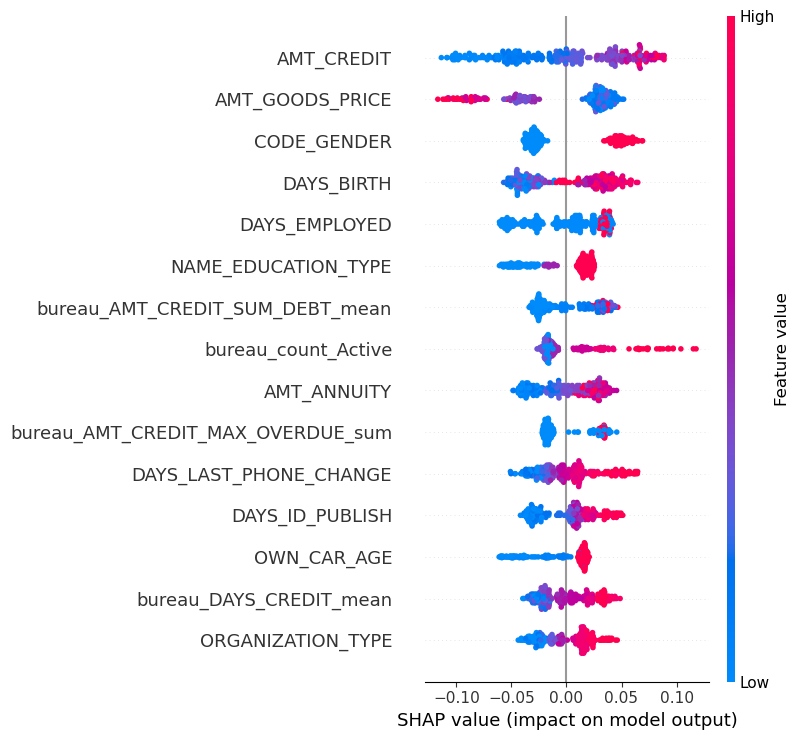

In [122]:
explainer_tree = shap.KernelExplainer(
    full_pipeline_rgf_no_ext["model"].predict_proba,
    data=sample_data.to_numpy(),
)

shap_values = explainer_tree(sample_data.to_numpy())

joblib.dump(
    {"sample_data": sample_data, "shap_vales": shap_values, "names": cols},
    "summary_data/shap_model1.joblib",
)

shap.summary_plot(
    shap_values[:, :, 1],
    sample_data.to_numpy(),
    feature_names=cols,
    max_display=15,
)

The most important features based on the model's internal values encompass various aspects of the applicant's background and credit history:

1. **Number of Days Since Last Credit Application:** This feature, derived from the credit bureau, holds significant importance, indicating the recency of the applicant's credit activity.

2. **Applicant Occupation:** The nature of the applicant's occupation emerges as a crucial determinant in the model's evaluation.

3. **Employment Length:** The duration of the applicant's employment is a key factor influencing the model's predictions.

4. **Age:** The age of the applicant is deemed important, suggesting a correlation between age and credit risk.

5. **Education:** The level of education attained by the applicant contributes to the model's assessment of default risk.

6. **Location:** The applicant's geographical location is identified as a significant factor influencing the model's predictions.

7. **Loan Size:** The size of the loan sought by the applicant is a critical variable in predicting default risk.

8. **Amount of Credit in Previously Refused Applications:** This feature captures information about the credit amounts in applications that were previously rejected.

9. **Sum of Current Debt:** The total amount of current debt carried by the applicant serves as an influential predictor in the model.

In addition to these values SHAP value analysis for a subset of samples showed the importance of when the applicant last changed his ID, the type of the organization where the client works, and the number of active credits that the person has from the credit bureau information.

## Model Summary

* The best pipeline included random oversampling of the minority class and a regularized greedy forest classifier.
* The model achieved a ROC-AUC of 0.749 on the test set without using external data, beating the pre-set success criteria.
* The most valuable features varied in nature from personal characteristics of the applicant, the amount of the loan to the applicants credit history.